In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploring Data

In [2]:
train=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitions/Flower predictions/Train.csv')
test=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Competitions/Flower predictions/Test.csv')

In [3]:
train.head()

,Area_Code,Locality_Code,Region_Code,Height,Diameter,Class,Species
0,4694,17,1609,3.0,5.0,7,48
1,781,7,1380,4.0,17.0,2,54
2,21014,6,1122,3.0,11.0,1,22
3,7326,6,556,3.0,34.0,7,25
4,13122,17,1752,5.0,16.0,2,128


In [4]:
train.describe()

,Area_Code,Locality_Code,Region_Code,Height,Diameter,Class,Species
count,12666.000000,12666.000000,12666.000000,12666.000000,12666.000000,12666.000000,12666.000000
mean,15790.986815,11.199274,1101.209300,5.600016,29.060003,3.632402,143.676772
std,9529.776852,5.811277,630.354516,3.561108,21.561272,2.119160,79.880127
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6548.500000,6.000000,569.000000,3.000000,13.000000,2.000000,72.000000
50%,15568.000000,11.000000,1099.000000,5.000000,25.000000,3.000000,172.000000
75%,25251.000000,16.000000,1650.000000,7.500000,39.000000,6.000000,203.000000
max,30897.000000,21.000000,2184.000000,60.000000,180.000000,7.000000,262.000000


In [5]:
train.isnull().sum()

Area_Code        0
Locality_Code    0
Region_Code      0
Height           0
Diameter         0
Class            0
Species          0
dtype: int64

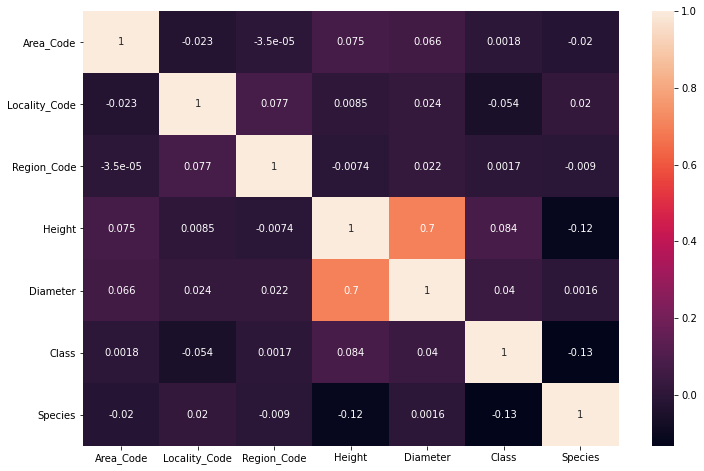

In [6]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True)

# Combining categorical and num columns using PCA and MCA 

In [7]:
pip install prince

In [8]:
import prince

In [9]:
y=train['Class']
train_no_target=train.drop('Class',axis=1)
flowers=pd.concat([train_no_target,test],axis=0)

In [10]:
categorical_cols= ['Area_Code','Locality_Code','Region_Code','Species']
numerical_cols = ['Height','Diameter']

In [11]:
mca = prince.MCA(n_components=2,random_state=202020).fit(flowers[categorical_cols])

In [12]:
train_no_target.loc[:,'MCA1'] = mca.transform(train_no_target[categorical_cols])[0]
test.loc[:,'MCA1']= mca.transform(test[categorical_cols])[0]

In [13]:
from sklearn.decomposition import PCA

pca= PCA(n_components=2,random_state=202020).fit(flowers[numerical_cols])
train_no_target.loc[:,'PCA1']= pca.transform(train_no_target[numerical_cols])[:,0]
test.loc[:,'PCA1']= pca.transform(test[numerical_cols])[:,0]

In [14]:
train_no_target.head()

,Area_Code,Locality_Code,Region_Code,Height,Diameter,Species,MCA1,PCA1
0,4694,17,1609,3.0,5.0,48,0.749322,-24.063324
1,781,7,1380,4.0,17.0,54,2.256277,-12.028807
2,21014,6,1122,3.0,11.0,22,-0.075749,-18.104645
3,7326,6,556,3.0,34.0,25,0.009431,4.736959
4,13122,17,1752,5.0,16.0,128,0.209120,-12.904761


In [15]:
train_no_target.corr()

,Area_Code,Locality_Code,Region_Code,Height,Diameter,Species,MCA1,PCA1
Area_Code,1.000000,-0.023094,-0.000035,0.074917,0.065838,-0.020178,-0.640088,0.066386
Locality_Code,-0.023094,1.000000,0.077059,0.008530,0.023524,0.019848,0.061730,0.023369
Region_Code,-0.000035,0.077059,1.000000,-0.007380,0.021943,-0.009033,0.333893,0.021504
Height,0.074917,0.008530,-0.007380,1.000000,0.700090,-0.115063,-0.052204,0.709824
Diameter,0.065838,0.023524,0.021943,0.700090,1.000000,0.001613,-0.021494,0.999906
Species,-0.020178,0.019848,-0.009033,-0.115063,0.001613,1.000000,0.041496,-0.000620
MCA1,-0.640088,0.061730,0.333893,-0.052204,-0.021494,0.041496,1.000000,-0.022206
PCA1,0.066386,0.023369,0.021504,0.709824,0.999906,-0.000620,-0.022206,1.000000


In [16]:
flowers=pd.concat([train_no_target,test],axis=0)

# Aggregate Feature Creation

We are trying to create new columns using aggregate feature creation techniques. We will create columns like Area_Code_mean_height , Region_Code_max_diameter etc..
We can also create a new columns like No.of unique species in Area_Code.This helps to extract out much more meaningful
features from data.

In [17]:
def agg_groupby(df,primary_key,operations,agg_cols):
  return df.groupby(primary_key).agg(operations).reset_index().rename(columns=agg_cols)

def left_join(df1,df2,primary_key):
  return df1.merge(df2,how='left',on=primary_key)

def aggregation(df,primary_key,operation,cols):
  for c in cols:
    df=left_join(df,
                 agg_groupby(df,
                             [primary_key],
                             {c:operation},
                             {c:primary_key+"_"+operation+"_"+c}),
                 primary_key)
  return df

In [18]:
# Lets create a new feature called height/diameter
flowers['ratio_height_diam']=np.where(flowers['Diameter']!=0,flowers['Height']/flowers['Diameter'],np.NAN)

In [19]:
aggregation_columns = ['Height','Diameter','MCA1','PCA1','ratio_height_diam']
operation=['mean','median','min','max','std']

In [20]:
# Analysing Area Code with Height,Diameter,MCA1,PCA1,ration_height_diam by using operation like mena ,median etc
for op in operation:
  flowers=aggregation(flowers,'Area_Code',op,aggregation_columns)

# Analysing Locality Code with Height,Diameter,MCA1,PCA1,ration_height_diam by using operation like mena ,median etc
for op in operation:
  flowers=aggregation(flowers,'Locality_Code',op,aggregation_columns)

# Analysing Region_Code with Height,Diameter,MCA1,PCA1,ration_height_diam by using operation like mena ,median etc
for op in operation:
  flowers=aggregation(flowers,'Region_Code',op,aggregation_columns)

# Analysing Species with Height,Diameter,MCA1,PCA1,ration_height_diam by using operation like mena ,median etc
for op in operation:
  flowers=aggregation(flowers,'Species',op,aggregation_columns)



> Selection of primary key:- Select a categorical column on which you wish to group the data. Say I want to analyse the data on the basis of all the unique area_codes in city..so area_code is primary key, or suppose on all unique species in city then species in primary key















In [21]:
print(len(flowers['Area_Code'].unique()))
print(len(flowers['Region_Code'].unique()))
print(len(flowers['Locality_Code'].unique()))
print(len(flowers['Species'].unique()))

30900
2185
22
263




> Till now we have choosen only numerical values like height,diameter to be aggreagte columns.

> We can also choose categorical column but we have to change our operation , we can apply mean or median. We use ooperation like nuinque , mode or frequency etc








In [22]:
flowers=aggregation(flowers,'Area_Code','nunique',['Species']) # No.of unique species in area_codes
flowers=aggregation(flowers,'Region_Code','nunique',['Species']) # No.of unique species in region_codes
flowers=aggregation(flowers,'Locality_Code','nunique',['Species']) # No.of unique species in locality_codes
flowers=aggregation(flowers,'Area_Code','nunique',['Region_Code']) # No.of unique region_code in area_codess
flowers=aggregation(flowers,'Area_Code','nunique',['Locality_Code']) # No.of unique locality_code in area_codes
flowers=aggregation(flowers,'Region_Code','nunique',['Locality_Code']) # No.of unique locality_code in region_codes

In [23]:
flowers['Area_Code_nunique_Locality_Code'].value_counts()

1     39225
17     1211
2      1008
3       243
13      148
15      118
18      109
4        95
6        42
5        22
Name: Area_Code_nunique_Locality_Code, dtype: int64

In [24]:
flowers['Locality_Code'].unique()

array([17,  7,  6, 19, 11,  8,  9, 13,  1,  2, 15,  3, 12,  5, 18, 21, 16,
       10, 20, 14,  4,  0])

# Data Preprocessing

In [25]:
train = flowers[:len(train)]
test  = flowers[len(train):]

In [26]:
for cols in categorical_cols:
    train[cols] = train[cols].astype(str)
    test[cols]  = test[cols].astype(str)

cate_features_index = np.where(train.dtypes == object)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
from sklearn.model_selection import  train_test_split
x_train,x_val,y_train,y_val=train_test_split(train,y,random_state=0,test_size=0.25)

# Catbbost

In [29]:
pip install catboost

In [30]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier(n_estimators=2000,random_state=0)

In [31]:
cat.fit(x_train,y_train,cat_features=cate_features_index,eval_set=(x_val,y_val))

Learning rate set to 0.086674
0:	learn: 1.8926260	test: 1.8852444	best: 1.8852444 (0)	total: 429ms	remaining: 14m 17s
1:	learn: 1.7564461	test: 1.7513273	best: 1.7513273 (1)	total: 761ms	remaining: 12m 40s
2:	learn: 1.6448054	test: 1.6396291	best: 1.6396291 (2)	total: 1.09s	remaining: 12m 6s
3:	learn: 1.5501043	test: 1.5462442	best: 1.5462442 (3)	total: 1.4s	remaining: 11m 38s
4:	learn: 1.4722647	test: 1.4688798	best: 1.4688798 (4)	total: 1.74s	remaining: 11m 33s
5:	learn: 1.4092990	test: 1.4066144	best: 1.4066144 (5)	total: 2.06s	remaining: 11m 23s
6:	learn: 1.3566935	test: 1.3545330	best: 1.3545330 (6)	total: 2.37s	remaining: 11m 15s
7:	learn: 1.3089677	test: 1.3061835	best: 1.3061835 (7)	total: 2.71s	remaining: 11m 15s
8:	learn: 1.2673130	test: 1.2661489	best: 1.2661489 (8)	total: 3.02s	remaining: 11m 9s
9:	learn: 1.2280762	test: 1.2275844	best: 1.2275844 (9)	total: 3.34s	remaining: 11m 3s
10:	learn: 1.1935100	test: 1.1925751	best: 1.1925751 (10)	total: 3.68s	remaining: 11m 5s
11:	l

In [32]:
from sklearn.metrics import log_loss
log_loss(pd.get_dummies(y_val),cat.predict_proba(x_val))

0.7200430084769595

In [35]:
cat_final=CatBoostClassifier(n_estimators=900,random_state=0)

In [36]:
cat_final.fit(train,y,cat_features=cate_features_index)

Learning rate set to 0.098452
0:	learn: 1.8497195	total: 429ms	remaining: 6m 25s
1:	learn: 1.6879293	total: 821ms	remaining: 6m 8s
2:	learn: 1.5637067	total: 1.2s	remaining: 5m 58s
3:	learn: 1.4713164	total: 1.56s	remaining: 5m 49s
4:	learn: 1.3990809	total: 1.94s	remaining: 5m 47s
5:	learn: 1.3365838	total: 2.33s	remaining: 5m 46s
6:	learn: 1.2857309	total: 2.7s	remaining: 5m 44s
7:	learn: 1.2400286	total: 3.08s	remaining: 5m 43s
8:	learn: 1.1995942	total: 3.48s	remaining: 5m 44s
9:	learn: 1.1639872	total: 3.86s	remaining: 5m 43s
10:	learn: 1.1349906	total: 4.24s	remaining: 5m 42s
11:	learn: 1.1082847	total: 4.63s	remaining: 5m 42s
12:	learn: 1.0865232	total: 5.01s	remaining: 5m 41s
13:	learn: 1.0667910	total: 5.39s	remaining: 5m 41s
14:	learn: 1.0480547	total: 5.77s	remaining: 5m 40s
15:	learn: 1.0306849	total: 6.12s	remaining: 5m 38s
16:	learn: 1.0157245	total: 6.52s	remaining: 5m 38s
17:	learn: 1.0000764	total: 6.93s	remaining: 5m 39s
18:	learn: 0.9862200	total: 7.34s	remaining: 5m

In [37]:
prob=cat.predict_proba(test)

In [40]:
result=pd.DataFrame(prob,columns=['Class0','Class1','Class2','Class3','Class4','Class5','Class6','Class7'])

In [41]:
result

,Class0,Class1,Class2,Class3,Class4,Class5,Class6,Class7
0,0.000230,0.008703,0.090925,0.050910,0.000054,0.000053,0.846879,0.002247
1,0.000830,0.007657,0.008243,0.014991,0.000205,0.000265,0.012941,0.954867
2,0.003163,0.000616,0.030251,0.836064,0.000020,0.001851,0.127840,0.000196
3,0.000288,0.003222,0.000635,0.000033,0.000016,0.000009,0.000091,0.995706
4,0.000177,0.008857,0.347346,0.012121,0.000018,0.000018,0.630581,0.000883
...,...,...,...,...,...,...,...,...
29550,0.000137,0.486227,0.361687,0.000778,0.000087,0.000057,0.008366,0.142662
29551,0.003049,0.784840,0.018500,0.000207,0.000778,0.000090,0.004860,0.187676
29552,0.001018,0.000489,0.052834,0.082479,0.000015,0.000083,0.862910,0.000172
29553,0.000397,0.000122,0.020851,0.820676,0.000011,0.000324,0.157552,0.000067


In [43]:
class_pred=cat_final.predict(test)

In [44]:
result['Predicted_Class']=class_pred

In [45]:
result

,Class0,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Predicted_Class
0,0.000230,0.008703,0.090925,0.050910,0.000054,0.000053,0.846879,0.002247,6
1,0.000830,0.007657,0.008243,0.014991,0.000205,0.000265,0.012941,0.954867,7
2,0.003163,0.000616,0.030251,0.836064,0.000020,0.001851,0.127840,0.000196,3
3,0.000288,0.003222,0.000635,0.000033,0.000016,0.000009,0.000091,0.995706,7
4,0.000177,0.008857,0.347346,0.012121,0.000018,0.000018,0.630581,0.000883,2
...,...,...,...,...,...,...,...,...,...
29550,0.000137,0.486227,0.361687,0.000778,0.000087,0.000057,0.008366,0.142662,1
29551,0.003049,0.784840,0.018500,0.000207,0.000778,0.000090,0.004860,0.187676,1
29552,0.001018,0.000489,0.052834,0.082479,0.000015,0.000083,0.862910,0.000172,6
29553,0.000397,0.000122,0.020851,0.820676,0.000011,0.000324,0.157552,0.000067,3
